In [32]:
%pip install timm==0.4.12

Note: you may need to restart the kernel to use updated packages.


In [33]:
import torch
from torch import nn
from einops import rearrange

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler,autocast
import torch.optim as optim

import sys
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
root_path = r"/home/srikanth/Interns/RGB_images"
dataset_path = os.listdir(root_path)
dataset_path

['Palmar wrist pronated', 'Pinch', 'Tripod', 'Palmar wrist neutral']

In [36]:
class_labels = []


for item in dataset_path:
    #print(item)
    all_objects = os.listdir(root_path + '/' +item)
    for top_object in all_objects:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            images = os.listdir(root_path + '/' +item + '/' +top_object + '/' +sub_object)
            for image in images:
                class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object +'/' +image)))
# class_labels
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
# df
y=list(df['labels'].values)
# y
image=df['image']
# image

In [37]:
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.3, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [38]:
classes=list(train_df['labels'].unique())
class_count=len(classes)

In [39]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [40]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64), antialias=True),
        transforms.Normalize( mean= [0.51158103, 0.47950193, 0.46153474],
                             std=[0.22355489, 0.22948845, 0.24873442])
        ])
        self.label_mapping = label2id
    # class ImageDataset(Dataset):
    # def __init__(self, df, label2id, input_size=224, transform=None):
    #     self.df = df
    #     self.label_mapping = label2id
    #     resize_value = self.calculate_resize_value(input_size)
    #     self.transform = transform if transform else transforms.Compose([
    #         transforms.Resize((resize_value, resize_value), antialias=True),
    #         transforms.CenterCrop(input_size),
    #         transforms.ToTensor(),
    #         transforms.Normalize(mean=[0.51158103, 0.47950193, 0.46153474],
    #                              std=[0.22355489, 0.22948845, 0.24873442])
    #     ])

    # def calculate_resize_value(self, input_size):
    #     return int((256 / 224) * input_size)

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [41]:
train_dataset = ImageDataset(train_df, transform=transforms)
val_dataset = ImageDataset(valid_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

In [42]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

class ConvBlock(nn.Module):
    def __init__(self, inplanes, outplanes, stride=1, res_conv=False, act_layer=nn.ReLU, groups=1,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6), drop_block=None, drop_path=None):
        super(ConvBlock, self).__init__()

        expansion = 2  # Reduced expansion
        med_planes = outplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=stride, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(outplanes)
        self.act3 = act_layer(inplace=True)

        if res_conv:
            self.residual_conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
            self.residual_bn = norm_layer(outplanes)

        self.res_conv = res_conv
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x, x_t=None, return_x_2=True):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x) if x_t is None else self.conv2(x + x_t)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x2 = self.act2(x)

        x = self.conv3(x2)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.res_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        x += residual
        x = self.act3(x)

        if return_x_2:
            return x, x2
        else:
            return x

class SimpleConformer(nn.Module):

    def __init__(self, patch_size=8, in_chans=3, num_classes=10, base_channel=32, channel_ratio=2, num_med_block=0,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        super().__init__()
        self.num_classes = num_classes
        stage_1_channel = int(base_channel * channel_ratio)

        # Stem stage: get the feature maps by conv block
        self.conv1 = nn.Conv2d(in_chans, 32, kernel_size=3, stride=2, padding=1, bias=False)  # 1 / 2 [112, 112]
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 1 / 4 [56, 56]

        # 1 stage
        self.conv_1 = ConvBlock(inplanes=32, outplanes=stage_1_channel, res_conv=True, stride=1)

        stage_2_channel = int(base_channel * channel_ratio * 2)
        # 2~3 stage
        for i in range(2, 4):
            s = 2 if i == 2 else 1
            in_channel = stage_1_channel if i == 2 else stage_2_channel
            res_conv = True if i == 2 else False
            self.add_module('conv_block_' + str(i),
                ConvBlock(
                    inplanes=in_channel, outplanes=stage_2_channel, res_conv=res_conv, stride=s))

        stage_3_channel = int(base_channel * channel_ratio * 2 * 2)
        # 4 stage
        s = 2
        in_channel = stage_2_channel
        res_conv = True
        self.add_module('conv_block_4',
            ConvBlock(
                inplanes=in_channel, outplanes=stage_3_channel, res_conv=res_conv, stride=s))

        self.fin_stage = 5
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.conv_cls_head = nn.Linear(stage_3_channel, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Stem stage
        x = self.maxpool(self.act1(self.bn1(self.conv1(x))))

        # 1 stage
        x, _ = self.conv_1(x)

        # Conv blocks
        for i in range(2, self.fin_stage):
            x, _ = eval('self.conv_block_' + str(i))(x)

        # Classification
        x = self.pooling(x).flatten(1)
        x = self.conv_cls_head(x)

        return x


num_classes = 4  # Adjust this based on your dataset
model = SimpleConformer(patch_size=8, in_chans=3, num_classes=num_classes, base_channel=32, channel_ratio=2, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)

In [44]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

In [45]:
from tqdm import tqdm
import torch

def trainVal(model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device):
    best_acc = 0.0
    min_loss = min_val_loss

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Using tqdm for progress tracking
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss_list = [criterion(o, labels) / len(outputs) for o in outputs]
                    loss = sum(loss_list)
                    preds = torch.max(outputs[0] + outputs[1], 1)[1]
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc)
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Update the learning rate
        # scheduler.step()  # Uncomment if using a learning rate scheduler

        # Save the model if it has the best validation accuracy so far
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'min_loss': epoch_loss
            }
        torch.save(state, '/home/srikanth/Interns/Rajasree/CSIO-Conformer/weight/simple-cnn.pth')

    return train_losses, train_accs, val_losses, val_accs, min_loss


In [46]:
# Define the initial minimum validation loss
min_val_loss = float('inf')

# Call the training function with the appropriate data loaders
train_losses, train_accs, val_losses, val_accs, min_loss = trainVal(
    model, criterion, optimizer, num_epochs, min_val_loss, train_loader, val_loader, device
)

Epoch 0/19
----------


Train Loss: 0.3837 Acc: 0.8679
Val Loss: 0.1863 Acc: 0.9388
Epoch 1/19
----------


Train Loss: 0.2231 Acc: 0.9320
Val Loss: 0.1384 Acc: 0.9580
Epoch 2/19
----------


Train Loss: 0.1891 Acc: 0.9437
Val Loss: 0.1200 Acc: 0.9652
Epoch 3/19
----------


Train Loss: 0.1752 Acc: 0.9488
Val Loss: 0.1091 Acc: 0.9660
Epoch 4/19
----------


Train Loss: 0.1653 Acc: 0.9516
Val Loss: 0.1264 Acc: 0.9595
Epoch 5/19
----------


Train Loss: 0.1576 Acc: 0.9541
Val Loss: 0.1027 Acc: 0.9684
Epoch 6/19
----------


Train Loss: 0.1522 Acc: 0.9554
Val Loss: 0.1069 Acc: 0.9663
Epoch 7/19
----------


Train Loss: 0.1473 Acc: 0.9572
Val Loss: 0.0955 Acc: 0.9702
Epoch 8/19
----------


Train Loss: 0.1428 Acc: 0.9588
Val Loss: 0.0920 Acc: 0.9727
Epoch 9/19
----------


Train Loss: 0.1401 Acc: 0.9596
Val Loss: 0.1024 Acc: 0.9674
Epoch 10/19
----------


Train Loss: 0.1356 Acc: 0.9612
Val Loss: 0.0906 Acc: 0.9720
Epoch 11/19
----------


Train Loss: 0.1337 Acc: 0.9621
Val Loss: 0.1066 Acc: 0.9649
Epoch 12/19
----------


Train Loss: 0.1319 Acc: 0.9623
Val Loss: 0.0875 Acc: 0.9725
Epoch 13/19
----------


Train Loss: 0.1285 Acc: 0.9637
Val Loss: 0.0936 Acc: 0.9717
Epoch 14/19
----------


Train Loss: 0.1277 Acc: 0.9638
Val Loss: 0.0964 Acc: 0.9709
Epoch 15/19
----------


Train Loss: 0.1272 Acc: 0.9634
Val Loss: 0.0937 Acc: 0.9716
Epoch 16/19
----------


Train Loss: 0.1239 Acc: 0.9650
Val Loss: 0.0934 Acc: 0.9718
Epoch 17/19
----------


Train Loss: 0.1241 Acc: 0.9647
Val Loss: 0.0860 Acc: 0.9730
Epoch 18/19
----------


Train Loss: 0.1231 Acc: 0.9656
Val Loss: 0.0870 Acc: 0.9731
Epoch 19/19
----------


Train Loss: 0.1212 Acc: 0.9660
Val Loss: 0.0833 Acc: 0.9734


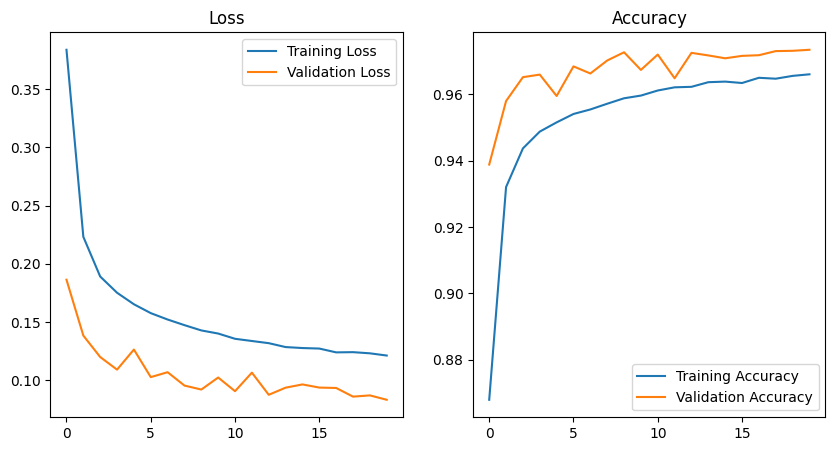

In [47]:
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays

train_losses = torch.tensor(train_losses)
val_losses = torch.tensor(val_losses)
train_accs = torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [48]:
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # If the model outputs a list of tensors
        if isinstance(outputs, list):
            batch_loss = 0.0
            for output in outputs:
                batch_loss += criterion(output, labels).item()
            test_loss = batch_loss / len(outputs)
            total_test_loss += test_loss * images.size(0)

            # For simplicity, assuming the first output for prediction evaluation
            output = outputs[0]
        else:
            test_loss = criterion(outputs, labels).item()
            total_test_loss += test_loss * images.size(0)
            output = outputs

        pred = output.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))


Test Accuracy: 97.55%


In [49]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[10834    68    43   508]
 [   13 11174    28    95]
 [   60    52 11018    99]
 [  110    22    10 11019]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11453
           1       0.99      0.99      0.99     11310
           2       0.99      0.98      0.99     11229
           3       0.94      0.99      0.96     11161

    accuracy                           0.98     45153
   macro avg       0.98      0.98      0.98     45153
weighted avg       0.98      0.98      0.98     45153

